## 실습02 201910938 김예진

## MNIST를 2 hidden layer 퍼셉트론으로 학습하기

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import ipywidgets as widgets
from ipywidgets import Layout,Box
from IPython.display import display
import time

### 1. MNIST train, test dataset 가져오기

In [2]:
# "": 현재 폴더에 MNIST 있음
mnist_train=dset.MNIST("", train=True, transform=transforms.ToTensor(),
                      target_transform=None, download=True) #train용으로 쓰겠다
mnist_test=dset.MNIST("", train=False, transform=transforms.ToTensor(),
                     target_transform=None, download=True) #Test용으로 쓰겠다.

### 2. 대략적인 데이터 형태

mnist_train 길이: 60000
mnist_test 길이: 10000
image data 형태: torch.Size([1, 28, 28])
label:  5


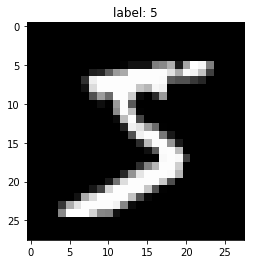

In [3]:
print "mnist_train 길이:", len(mnist_train)
print "mnist_test 길이:", len(mnist_test)

#데이터 하나 형태
image, label=mnist_train.__getitem__(0) #0번째 데이터
print "image data 형태:", image.size()
print "label: ", label

#그리기
img=image.numpy() #imgae 타입을 numpy로 변환 (1, 28,28)
plt.title("label: %d" %label)
plt.imshow(img[0], cmap='gray')
plt.show()

### 3. 데이터 로드함수

In [4]:
# hyper parameters
batch_size=1024
learning_rate=0.01
num_epoch=400

In [5]:
train_loader=torch.utils.data.DataLoader(mnist_train,
                                        batch_size=batch_size,
                                        shuffle=True, num_workers=2,
                                        drop_last=True)
test_loader=torch.utils.data.DataLoader(mnist_test,
                                        batch_size=batch_size,
                                        shuffle=False, num_workers=2,
                                        drop_last=True)

### 데이터 로드함수 이해하기

[0]
한 번에 로드되는 데이터 크기 1024


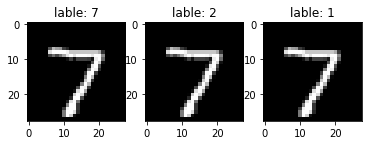

[1]
한 번에 로드되는 데이터 크기 1024


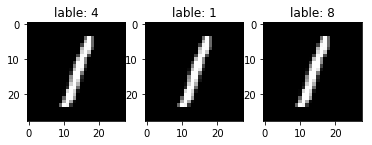

[2]
한 번에 로드되는 데이터 크기 1024


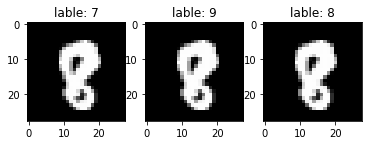

[3]
한 번에 로드되는 데이터 크기 1024


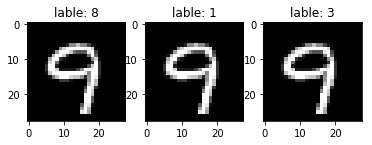

[4]
한 번에 로드되는 데이터 크기 1024


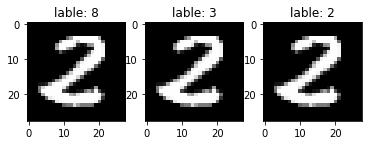

[5]
한 번에 로드되는 데이터 크기 1024


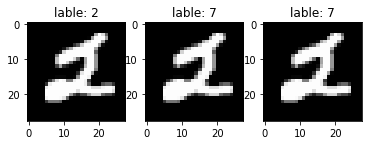

In [6]:
n=3 #샘플로 그려볼 데이터 개수
for i, [imgs, labels] in enumerate(test_loader): #batchsize만큼
    if i>5:
        break
        
    print "[%d]" %i
    print "한 번에 로드되는 데이터 크기", len(imgs)
    
    #그리기
    for j in range(n):
        img=imgs[i].numpy() #imgae타입을 numpy로 변환(1,28,28)
        img=img.reshape((img.shape[1], img.shape[2])) #(1,28,28)->(28,28)
        #print img.shape
        
        plt.subplot(1,n,j+1) #(1,3) 형태 플랏의 j번째 자리에 그리겠다
        plt.imshow(img, cmap='gray')
        plt.title("lable: %d" %labels[j])
    plt.show()

### 4. 모델선언

In [7]:
#모델선언
# * 퍼셉트론(2 hidden layer) *
model=nn.Sequential(   #28*28 - 256 - 128 - 10
    nn.Linear(28*28,256),
    nn.Sigmoid(), #nn.ReLu(),   #nn.Sigmoid()
    nn.Linear(256,128),
    nn.Linear(128,10),
)
# 파라미터 보기
# print(list(model.parameters())) #초기 파라미터 출력

#model=model.cuba()  #***GPU 가속***

In [8]:
def ComputeAccr(dloader, imodel):
    correct=0
    total=0
    
    for j, [imgs, labels] in enumerate(dloader): #batch_size만큼
        img=imgs #x
        label=Variable(labels) #y
        #label=Variable(labels).cuba()
        #.cuba(): GPU에 로드되기 위함. CPU로 설정되있으면 에러
        
        #(batch_size,1,28,28)->(batch_size,28,28)
        img=img.reshape((img.shape[0], img.shape[2], img.shape[3]))
        #(batch_size,28,28)->(batch_size,28*28)
        img=img.reshape((img.shape[0], img.shape[1]*img.shape[2]))
        img=Variable(img, requires_grad=False) # False for Forward Propogation
        #.cuba()
        
        output=imodel(img) #forword prop.
        _, output_index=torch.max(output,1)
        
        total+=label.size(0)
        correct+=(output_index==label).sum().float()
    print("Accuracy of Test Data: {}". format(100*correct/total))

In [9]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 11.2955732346


### 5. loss, optimizer

In [10]:
loss_func=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(), lr=learning_rate)

### 6. 학습

In [11]:
epoch=widgets.IntProgress(min=0, max=num_epoch, description='epoch')
display(epoch)

for i in range(num_epoch):
    
    epoch.value+=1
    
    for j, [imgs, labels] in enumerate(train_loader): #batch_size만큼
        img=imgs #(batch_size, 1,28,28)
        label=Variable(labels) #(batch_size)
        #label=Variable(labels).cuba()
                
        #(batch_size,1,28,28)->(batch_size,28,28)
        img=img.reshape((img.shape[0], img.shape[2], img.shape[3]))
        #(batch_size,28,28)->(batch_size,28*28)
        img=img.reshape((img.shape[0], img.shape[1]*img.shape[2]))
        img=Variable(img, requires_grad=True) # True for Backward Propogation
        
        optimizer.zero_grad()
        output=model(img) #forward prop.
        loss=loss_func(output, label)
        
        loss.backward() #back prop.
        optimizer.step() #weight 조정
        
    if i%50==0:
        print("%d.." %i)
        ComputeAccr(test_loader, model)
        print loss

IntProgress(value=0, description=u'epoch', max=400)

0..
Accuracy of Test Data: 11.2955732346
tensor(2.2939, grad_fn=<NllLossBackward>)
50..
Accuracy of Test Data: 78.8411483765
tensor(0.7141, grad_fn=<NllLossBackward>)
100..
Accuracy of Test Data: 88.205291748
tensor(0.4560, grad_fn=<NllLossBackward>)
150..
Accuracy of Test Data: 89.930557251
tensor(0.3496, grad_fn=<NllLossBackward>)
200..
Accuracy of Test Data: 90.8203125
tensor(0.3358, grad_fn=<NllLossBackward>)
250..
Accuracy of Test Data: 91.3736953735
tensor(0.3459, grad_fn=<NllLossBackward>)
300..
Accuracy of Test Data: 91.6341171265
tensor(0.3083, grad_fn=<NllLossBackward>)
350..
Accuracy of Test Data: 91.89453125
tensor(0.2929, grad_fn=<NllLossBackward>)


### 7. 테스트

In [12]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 92.111541748


### 8. 학습된 파라미터 저장

In [14]:
netname='./nets/mlp_weight.pkl'
torch.save(model, netname, )